# Drowsiness Model

In [9]:
import numpy as np 
import pandas as pd 
import os
import cv2

In [10]:
labels = os.listdir("./input/drowsiness-dataset/train")

In [1]:
import matplotlib.pyplot as plt


In [13]:
a = plt.imread("./input/drowsiness-dataset/train/yawn/10.jpg")

# Yawn and no Yawn 

In [16]:
def face_for_yawn(direc="./input/drowsiness-dataset/train", face_cas_path="./input/prediction-images/haarcascade_frontalface_default.xml"):
    yaw_no = []
    IMG_SIZE = 145
    categories = ["yawn", "no_yawn"]
    for category in categories:
        path_link = os.path.join(direc, category)
        class_num1 = categories.index(category)
        print(class_num1)
        for image in os.listdir(path_link):
            image_array = cv2.imread(os.path.join(path_link, image), cv2.IMREAD_COLOR)
            face_cascade = cv2.CascadeClassifier(face_cas_path)
            faces = face_cascade.detectMultiScale(image_array, 1.3, 5)
            for (x, y, w, h) in faces:
                img = cv2.rectangle(image_array, (x, y), (x+w, y+h), (0, 255, 0), 2)
                roi_color = img[y:y+h, x:x+w]
                resized_array = cv2.resize(roi_color, (IMG_SIZE, IMG_SIZE))
                yaw_no.append([resized_array, class_num1])
    return yaw_no


yawn_no_yawn = face_for_yawn()

0
1


# Closed and Open Eye

In [17]:
def get_data(dir_path="./input/drowsiness-dataset/train/", face_cas="./input/prediction-images/haarcascade_frontalface_default.xml", eye_cas="../input/prediction-images/haarcascade.xml"):
    labels = ['Closed', 'Open']
    IMG_SIZE = 145
    data = []
    for label in labels:
        path = os.path.join(dir_path, label)
        class_num = labels.index(label)
        class_num +=2
        print(class_num)
        for img in os.listdir(path):
            try:
                img_array = cv2.imread(os.path.join(path, img), cv2.IMREAD_COLOR)
                resized_array = cv2.resize(img_array, (IMG_SIZE, IMG_SIZE))
                data.append([resized_array, class_num])
            except Exception as e:
                print(e)
    return data

In [18]:
data_train = get_data()

2
3


In [19]:
def append_data():
    yaw_no = face_for_yawn()
    data = get_data()
    yaw_no.extend(data)
    return np.array(yaw_no)

In [20]:
new_data = append_data()

0
1
2
3


C:\Users\gokul\AppData\Local\Temp\ipykernel_24824\3548787232.py:5: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return np.array(yaw_no)


In [21]:
X = []
y = []
for feature, label in new_data:
    X.append(feature)
    y.append(label)

In [22]:
X = np.array(X)
X = X.reshape(-1, 145, 145, 3)

In [23]:
from sklearn.preprocessing import LabelBinarizer
label_bin = LabelBinarizer()
y = label_bin.fit_transform(y)

In [24]:
y = np.array(y)

In [25]:
from sklearn.model_selection import train_test_split
seed = 42
test_size = 0.30
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=seed, test_size=test_size)

In [26]:
len(X_test)

578

In [27]:
from tensorflow.keras.layers import Input, Lambda, Dense, Flatten, Conv2D, MaxPooling2D, Dropout
from tensorflow.keras.models import Model
from tensorflow.keras.models import Sequential
from keras.preprocessing.image import ImageDataGenerator
import tensorflow as tf

In [28]:
tf.__version__

'2.10.0'

In [29]:
import keras
keras.__version__

'2.10.0'

In [30]:
train_generator = ImageDataGenerator(rescale=1/255, zoom_range=0.2, horizontal_flip=True, rotation_range=30)
test_generator = ImageDataGenerator(rescale=1/255)

train_generator = train_generator.flow(np.array(X_train), y_train, shuffle=False)
test_generator = test_generator.flow(np.array(X_test), y_test, shuffle=False)

# Model

In [31]:
model = Sequential()

model.add(Conv2D(256, (3, 3), activation="relu", input_shape=X_train.shape[1:]))
model.add(MaxPooling2D(2, 2))

model.add(Conv2D(128, (3, 3), activation="relu"))
model.add(MaxPooling2D(2, 2))

model.add(Conv2D(64, (3, 3), activation="relu"))
model.add(MaxPooling2D(2, 2))

model.add(Conv2D(32, (3, 3), activation="relu"))
model.add(MaxPooling2D(2, 2))

model.add(Flatten())
model.add(Dropout(0.5))

model.add(Dense(64, activation="relu"))
model.add(Dense(4, activation="softmax"))

model.compile(loss="categorical_crossentropy", metrics=["accuracy"], optimizer="adam")

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 143, 143, 256)     7168      
                                                                 
 max_pooling2d (MaxPooling2D  (None, 71, 71, 256)      0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 69, 69, 128)       295040    
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 34, 34, 128)      0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 32, 32, 64)        73792     
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 16, 16, 64)       0

# Training the Model

In [33]:
history = model.fit(train_generator, epochs=90, validation_data=test_generator, shuffle=True, validation_steps=len(test_generator))

Epoch 1/90
43/43 [==============================] - 103s 2s/step - loss: 0.7328 - accuracy: 0.7030 - val_loss: 0.4375 - val_accuracy: 0.8270
Epoch 2/90
43/43 [==============================] - 100s 2s/step - loss: 0.4404 - accuracy: 0.8070 - val_loss: 0.3117 - val_accuracy: 0.8754
Epoch 3/90
43/43 [==============================] - 100s 2s/step - loss: 0.3548 - accuracy: 0.8463 - val_loss: 0.2545 - val_accuracy: 0.9048
Epoch 4/90
43/43 [==============================] - 106s 2s/step - loss: 0.3186 - accuracy: 0.8552 - val_loss: 0.2845 - val_accuracy: 0.8841
Epoch 5/90
43/43 [==============================] - 102s 2s/step - loss: 0.2768 - accuracy: 0.8909 - val_loss: 0.2050 - val_accuracy: 0.9083
Epoch 6/90
43/43 [==============================] - 101s 2s/step - loss: 0.2517 - accuracy: 0.8968 - val_loss: 0.1966 - val_accuracy: 0.9135
Epoch 7/90
43/43 [==============================] - 101s 2s/step - loss: 0.2525 - accuracy: 0.8916 - val_loss: 0.2049 - val_accuracy: 0.9152
Epoch 8/90
43

# History

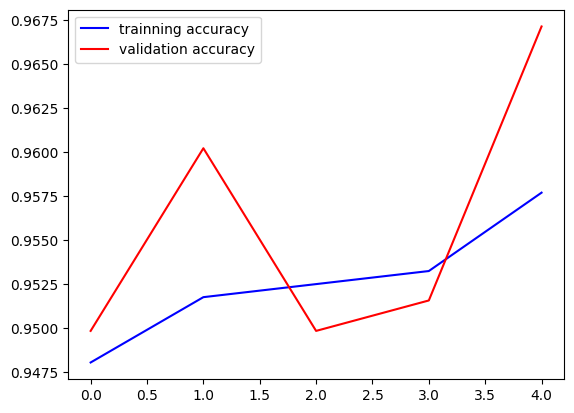

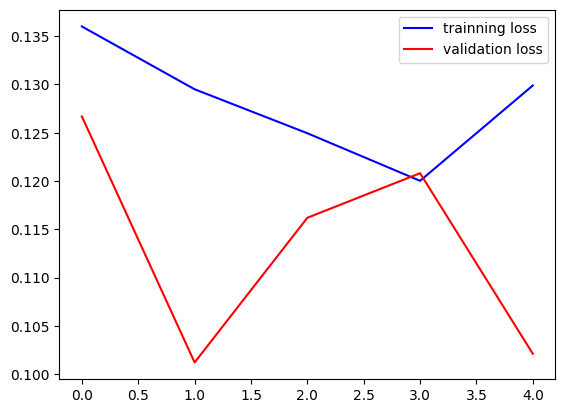

In [ ]:
accuracy = history.history['accuracy']
val_accuracy = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(len(accuracy))

plt.plot(epochs, accuracy, "b", label="trainning accuracy")
plt.plot(epochs, val_accuracy, "r", label="validation accuracy")
plt.legend()
plt.show()

plt.plot(epochs, loss, "b", label="trainning loss")
plt.plot(epochs, val_loss, "r", label="validation loss")
plt.legend()
plt.show()

In [34]:
model.save("drowsiness1.h5")

In [35]:
model.save("drowsiness1.model")

INFO:tensorflow:Assets written to: drowsiness1.model\assets


INFO:tensorflow:Assets written to: drowsiness1.model\assets


In [ ]:
prediction = model.predict(X_test)

19/19 [==============================] - 10s 505ms/step


In [ ]:
prediction

array([[0., 0., 0., 1.],
       [0., 0., 0., 1.],
       [0., 0., 1., 0.],
       ...,
       [0., 0., 0., 1.],
       [0., 0., 1., 0.],
       [0., 0., 1., 0.]], dtype=float32)

# classification report

In [ ]:
labels_new = ["yawn", "no_yawn", "Closed", "Open"]

# predicting function

In [41]:
labels_new = ["yawn", "no_yawn", "Closed", "Open"]
IMG_SIZE = 145
def prepare(filepath, face_cas="./input/prediction-images/haarcascade_frontalface_default.xml"):
    img_array = cv2.imread(filepath, cv2.IMREAD_COLOR)
    img_array = img_array / 255
    resized_array = cv2.resize(img_array, (IMG_SIZE, IMG_SIZE))
    return resized_array.reshape(-1, IMG_SIZE, IMG_SIZE, 3)


In [ ]:
image_path = "./input/drowsiness-dataset/train/Closed/_101.jpg"
image = cv2.imread(image_path)
image = cv2.resize(image, (145, 145)) 
image = np.expand_dims(image, axis=0) 
image = image / 255.0 
predictions = model.predict(image)


1/1 [==============================] - 0s 49ms/step


In [ ]:
predictions

array([[5.8259157e-08, 5.6620236e-10, 9.9996829e-01, 3.1733114e-05]],
      dtype=float32)

# Prediction 
## 0-yawn, 1-no_yawn, 2-Closed, 3-Open

In [3]:
import cv2
import numpy as np
import tensorflow as tf

model = tf.keras.models.load_model("drowsiness1.h5")

faceCascade = cv2.CascadeClassifier(cv2.data.haarcascades + 'haarcascade_frontalface_default.xml')
eye_cascade = cv2.CascadeClassifier(cv2.data.haarcascades + 'haarcascade_eye.xml')
cap = cv2.VideoCapture(1)

if not cap.isOpened():
    cap = cv2.VideoCapture(0)
if not cap.isOpened():
    raise IOError("Cannot open webcam")

while True:
    ret, frame = cap.read()
    
    if not ret:
        continue
    
    gray = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
    faces = faceCascade.detectMultiScale(gray, 1.1, 4)
    
    for (x, y, w, h) in faces:
        cv2.rectangle(frame, (x, y), (x+w, y+h), (0, 255, 0), 2)
        roi_gray = gray[y:y+h, x:x+w]
        roi_color = frame[y:y+h, x:x+w]
        eyes = eye_cascade.detectMultiScale(roi_gray)
        
        for (ex, ey, ew, eh) in eyes:
            eyes_roi = roi_color[ey: ey+eh, ex:ex + ew]
            final_image = cv2.resize(eyes_roi, (145, 145))
            final_image = np.expand_dims(final_image, axis=0)
            final_image = final_image / 255.0
            prediction = model.predict(final_image)
            a = np.argmax(prediction)
            if a == 3:
                status = "Active"
            elif a == 2:
                status = "Drow"
            else:
                status = "Unknown"

            font = cv2.FONT_HERSHEY_SIMPLEX
            cv2.putText(frame, status, (50, 50), font, 3, (0, 0, 255), 2, cv2.LINE_4)
    
    cv2.imshow("Drowsiness Detector", frame)
    
   
    if cv2.waitKey(1) & 0xFF == ord("q"):
        break

cap.release()
cv2.destroyAllWindows()


1/1 [==============================] - 0s 70ms/step


KeyboardInterrupt: 

In [ ]:
prediction = model.predict([prepare("./input/drowsiness-dataset/train/Closed/_101.jpg")])
np.argmax(prediction)

1/1 [==============================] - 0s 100ms/step


2

In [49]:
prediction = model.predict([prepare("./input/drowsiness-dataset/train/Open/_104.jpg")])
prediction

1/1 [==============================] - 0s 106ms/step


array([[2.5418317e-21, 9.0417086e-28, 3.2823204e-12, 1.0000000e+00]],
      dtype=float32)

In [43]:
labels_new = ["yawn", "no_yawn", "Closed", "Open"]
IMG_SIZE = 145
def prepare(filepath, face_cas="./input/prediction-images/haarcascade_frontalface_default.xml"):
    img_array = cv2.imread(filepath, cv2.IMREAD_COLOR)
    img_array = img_array / 255
    resized_array = cv2.resize(img_array, (IMG_SIZE, IMG_SIZE))
    return resized_array.reshape(-1, IMG_SIZE, IMG_SIZE, 3)

prediction = model.predict([prepare("./input/drowsiness-dataset/train/yawn/163.jpg")])
np.argmax(prediction)

1/1 [==============================] - 0s 113ms/step


3

In [ ]:
prediction = model.predict([prepare("./input/drowsiness-dataset/train/yawn/113.jpg")])
np.argmax(prediction)

1/1 [==============================] - 0s 42ms/step


3